In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid

from helpers import plot_losses

In [4]:
def run_logistic(A, y, param, logging=False):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=logging)
    if logging:
        print()
        print('{0} - score: {1:.4f}'.format(param, m.score(A, y)))
    return list_losses

In [5]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [6]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [7]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load Higgs Boson dataset

In [8]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [9]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.748436
Final loss: 0.507818140197605


### Computing with Decentralized SGD

In [10]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 10
params_disconnected = dict(num_epoch=15, lr_type='bottou',
                           initial_lr=0.05, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=2048,
                           method='plain', topology='disconnected', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

### Real Social Network Graph

In [11]:
import networkx as nx

In [12]:
G = nx.read_gml('power.gml', label=None)
G = G.to_undirected()

print("number of nodes " + str(G.number_of_nodes()))
print("number of edges " + str(G.number_of_edges()))

compute_loss_every_bigger = 10

number of nodes 4941
number of edges 6594


In [13]:
# Takes time, but works
params_complete = params_disconnected.copy()
params_complete['topology'] = 'complete'
params_complete['n_machines'] = G.number_of_nodes()
losses_complete = run_logistic(A, y, params_complete, logging=True)

length of indices: 4999
length of last machine indices: 50
Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        15s       0.6033    0.7072        
[2/15]     [50/50]        33s       0.5900    0.7107        
[3/15]     [50/50]        51s       0.5847    0.7127        
[4/15]     [50/50]        65s       0.5816    0.7140        
[5/15]     [50/50]        80s       0.5793    0.7152        
[6/15]     [50/50]        100s      0.5775    0.7168        
[7/15]     [50/50]        114s      0.5759    0.7179        
[8/15]     [50/50]        130s      0.5746    0.7186        
[9/15]     [50/50]        146s      0.5734    0.7194        
[10/15]    [50/50]        162s      0.5725    0.7201        
[11/15]    [50/50]        178s      0.5716    0.7207        
[12/15]    [50/50]        193s      0.5708    0.7212        
[13/15]    [50/50]        208s      0.5701    0.7217        
[14/15]    [50/50]        224s      0.5695    0.7224        
[15/15]    [50/50]        

In [14]:
params_real = params_disconnected.copy()
params_real['topology'] = nx.adjacency_matrix(G).toarray()
params_real['n_machines'] = G.number_of_nodes()
losses_real = run_logistic(A, y, params_real, logging=True)

length of indices: 4999
length of last machine indices: 50
Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        15s       0.6028    0.7068        
[2/15]     [50/50]        30s       0.5896    0.7105        
[3/15]     [50/50]        45s       0.5851    0.7127        
[4/15]     [50/50]        61s       0.5836    0.7138        
[5/15]     [50/50]        76s       0.5832    0.7151        
[6/15]     [50/50]        91s       0.5838    0.7164        
[7/15]     [50/50]        106s      0.5827    0.7179        
[8/15]     [50/50]        121s      0.5822    0.7189        
[9/15]     [50/50]        136s      0.5817    0.7195        
[10/15]    [50/50]        151s      0.5806    0.7205        
[11/15]    [50/50]        166s      0.5798    0.7214        
[12/15]    [50/50]        182s      0.5799    0.7221        
[13/15]    [50/50]        197s      0.5800    0.7226        
[14/15]    [50/50]        213s      0.5790    0.7236        
[15/15]    [50/50]        

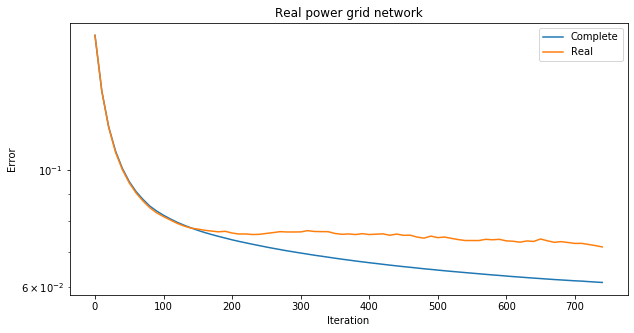

In [16]:
iterations_indices = np.arange(0, losses_real.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete[:-1], losses_real[:-1])),
            iterations_indices[:-1], optimum_loss=optimum_loss,
            labels=["Complete","Real"], title="Real power grid network", 
            save_as_pdf=True, pdf_name="real_net")